In [129]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [128]:
# neural networks stuff

class convolutional_layer():
    def __init__(self, input_shape, kernel_size, depth):
        
        # input_shape = (depth, width, height) of each input
        input_depth, input_height, input_width = input_shape
        self.input_shape = input_shape
        self.input_depth = input_depth
        
        
        # depth = number of kernels
        self.depth = depth
        
        # output shape
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        
        # initialize kernels (weights) and biases
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.weights = 0.1*np.random.randn(depth, input_depth, kernel_size, kernel_size)
        self.biases = np.zeros(self.output_shape)

        # initialize momentums and caches (for ADAM)
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    def forward(self, inputs):
        
        # save inputs
        self.inputs = inputs
        
        # initialize output array
        self.output = np.copy(self.biases)
        
        # loop over kernels
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += correlate2d(self.inputs[j], self.weights[i, j], "valid")
                
    def backward(self, dinputs):

        # initialize gradients
        self.dweights = np.zeros(self.kernels_shape) # weights = kernels Kij
        self.dinputs = np.zeros(self.input_shape)
        self.dbiases = dinputs
        
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.dweights[i, j] = correlate2d(self.inputs[j], dinputs[i], "valid")
                self.dinputs[j] += convolve2d(dinputs[i], self.weights[i, j], "full")


class reshape:
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, inputs):
        self.output = np.reshape(inputs, self.output_shape)

    def backward(self, dinputs):
        self.dinputs = np.reshape(dinputs, self.input_shape)
        
class maxpool2:
  # A Max Pooling layer using a pool size of 2.

    def iterate_regions(self, image):
        # Generates non-overlapping 2x2 image regions to pool over.
        
        
        
        _, h, w = image.shape

        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                region = image[:, (2*i):(2*i + 2), (2*j):(2*j + 2)]
                yield region, i, j

    def forward(self, inputs):

        self.inputs = inputs
        depth, h, w = inputs.shape
        self.output = np.zeros((depth, h // 2, w // 2))

        for region, i, j in self.iterate_regions(inputs):
            self.output[:, i, j] = np.max(region, axis=(1, 2))

    
    def backward(self, dinputs):
 
        self.dinputs = np.zeros(self.inputs.shape)

        for region, i, j in self.iterate_regions(self.inputs):
            d, h, w = region.shape
            max_idx = region.reshape(d,-1).argmax(axis=1)
            max_pos = np.column_stack(np.unravel_index(max_idx, (h,w)))
            self.dinputs[:, (2*i):(2*i + 2), (2*j):(2*j + 2)][np.arange(d),max_pos[:,0],max_pos[:,1]] = dinputs[:,i,j]
            
            
# recurrent layer
class recurrent_layer:
    
    
    def __init__(self,n_inputs, n_neurons): 
        
        # initialization (weights and biases)
        self.weights = 0.1*np.random.randn(n_inputs+n_neurons,n_neurons)
        self.biases = np.zeros((1,n_neurons))
        
        # save sizes
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
        
    # forward pass: pass the data through the layer
    def forward(self, inputs1, inputs2):
        # save inputs
        self.inputs1 = inputs1
        self.inputs2 = inputs2
        self.inputs = np.c_[inputs1,inputs2]
        
        # output
        self.output = self.inputs.dot(self.weights) + self.biases
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)[:,0:self.n_inputs]
            
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# neural network layer
class layer:
    
    # initialization (weights and biases)
    def __init__(self,n_inputs, n_neurons): # self represents the instance of the class
        self.weights = 0.1*np.random.randn(n_inputs,n_neurons) # small random numbers
        self.biases = np.zeros((1,n_neurons))# zeros
        
        # initialize momentums and caches
        self.weight_momentums = np.zeros(self.weights.shape)
        self.weight_caches = np.zeros(self.weights.shape)
        self.bias_momentums = np.zeros(self.biases.shape)
        self.bias_caches = np.zeros(self.biases.shape)
        
    # forward pass: pass the data through the layer
    def forward(self, inputs):
        # we need to store the output
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):
        
        # gradient
        self.dinputs = dinputs.dot(self.weights.T)
        
        # gradients on parameters
        self.dweights = self.inputs.T.dot(dinputs)
        self.dbiases = np.sum(dinputs, axis=0, keepdims=True)
        
# activation function
class ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dinputs):

        # copy dvalues
        self.dinputs = dinputs.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
        
# linear activation function: outputs = inputs
class linear:

    def forward(self, inputs):
        # flatten the output
        self.inputs = inputs
        self.output = inputs.flatten()

    def backward(self, dinputs):
        # derivative of x is 1 
        self.dinputs = dinputs.copy().reshape(-1,1) # reshape the result as a column vector
        
# mean squeared error        
class loss_mse():

    def forward(self, y_pred, y_true):

    # calculate loss
        sample_losses = (y_true - y_pred)**2
        # return losses
        return sample_losses

    def backward(self, y_pred, y_true):

        # number of data points
        samples = len(y_pred)

        # gradient 
        self.dinputs = -2 * (y_true - y_pred) 

        # normalize gradient
        self.dinputs = self.dinputs / samples
        
# softmax activation function
class softmax:
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
        
    def backward(self,dinputs):

        
        # initialized gradient array
        self.dinputs = np.zeros(dinputs.shape)
        
        # For each data point, compute gradient
        for i in range(len(dinputs)):
            
            # probabilities 
            proba = self.output[i]
            
            # loss gradients
            dinputs_row = dinputs[i]


            # calculate derivative matrix of the output
            derivative_matrix = np.diag(proba) - proba.reshape(-1,1).dot(proba.reshape(1,-1))
            
            # store gradient
            self.dinputs[i] = dinputs_row.dot(derivative_matrix)
            

class loss_crossentropy():
    
    def forward(self, y_hat, y):
        
        # number of data points
        n_samples = len(y)
        
        # clip data to prevent division by 0
        y_hat_clipped = np.clip(y_hat, 1e-7,1 - 1e-7)
        
        # predicted class probabilities
        pred_proba = y_hat_clipped[range(n_samples),y]
       
        # sample losses 
        losses = -np.log(pred_proba)
        
        return losses
    
    
    def backward(self, p, y):
        
        
        # number of samples
        n_samples = len(y)
    
        # one-hot matrix
        Y = np.zeros(p.shape)
        Y[np.arange(len(y)),y] = 1
        
        # calculate gradient
        self.dinputs = -Y / np.clip(p,a_min=1e-200,a_max=1)
        
        # normalized gradient
        self.dinputs = self.dinputs / n_samples
            
        
class optimizer_GD:

    def __init__(self, learning_rate=1):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        
        # apply gradient descent iteration
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
# Adam optimizer
class optimizer_ADAM:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # initial learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
                   
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_caches = self.beta_2 * layer.weight_caches + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_caches = self.beta_2 * layer.bias_caches + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_caches_corrected = layer.weight_caches / (1 - self.beta_2 ** (self.epoch + 1))
        bias_caches_corrected = layer.bias_caches / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_caches_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_caches_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1
    
# dropout layer
class dropout:
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dinputs):
        self.dinputs = dinputs*self.mask

# Problem 2: Traffic forecasting

In [202]:
# load traffic and weather datasets
data = pd.read_csv('traffic.csv',index_col='Date',parse_dates=True)['Fremont Bridge Total']
data

Date
2019-11-01 00:00:00     12.0
2019-11-01 01:00:00      7.0
2019-11-01 02:00:00      1.0
2019-11-01 03:00:00      6.0
2019-11-01 04:00:00      6.0
                       ...  
2021-08-31 19:00:00    139.0
2021-08-31 20:00:00     95.0
2021-08-31 21:00:00     48.0
2021-08-31 22:00:00     24.0
2021-08-31 23:00:00     22.0
Name: Fremont Bridge Total, Length: 144374, dtype: float64

In [203]:
data = data['2021/06':'2021/08'].to_numpy()

In [204]:
np.save('june-july.npy', data)

The data contains hourly number of bicycle trips across Seattle’s Fremont bridge (June-July, 2021)

In [205]:
data = np.load('june-july.npy')

Text(0.5, 1.0, 'hourly number of bicycle trips across Seattle’s Fremont bridge')

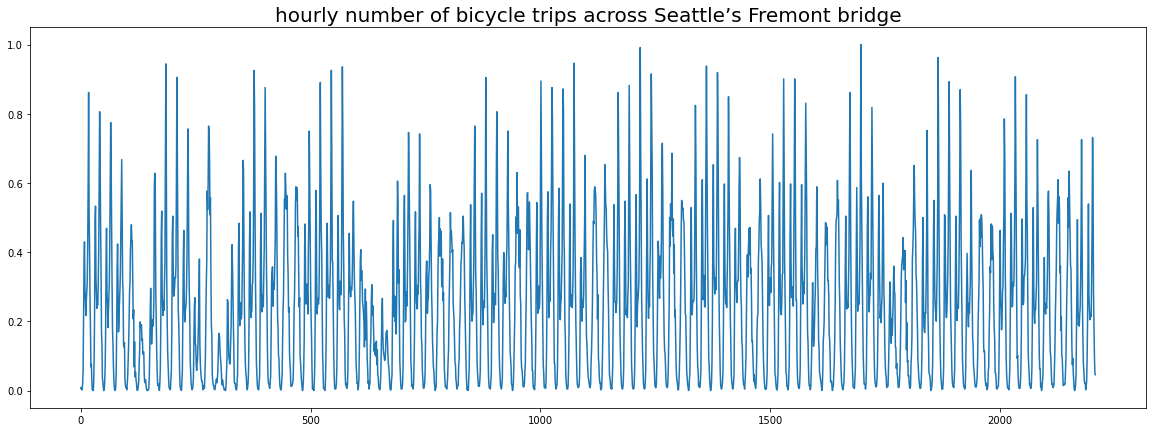

In [210]:
plt.figure(figsize=(20,7))
plt.plot(data)
plt.title('hourly number of bicycle trips across Seattle’s Fremont bridge', fontsize=20)

In [208]:
# scale data to the interval [0,1]
data = data/data.max()

Text(0.5, 1.0, 'scaled hourly number of bicycle trips across Seattle’s Fremont bridge')

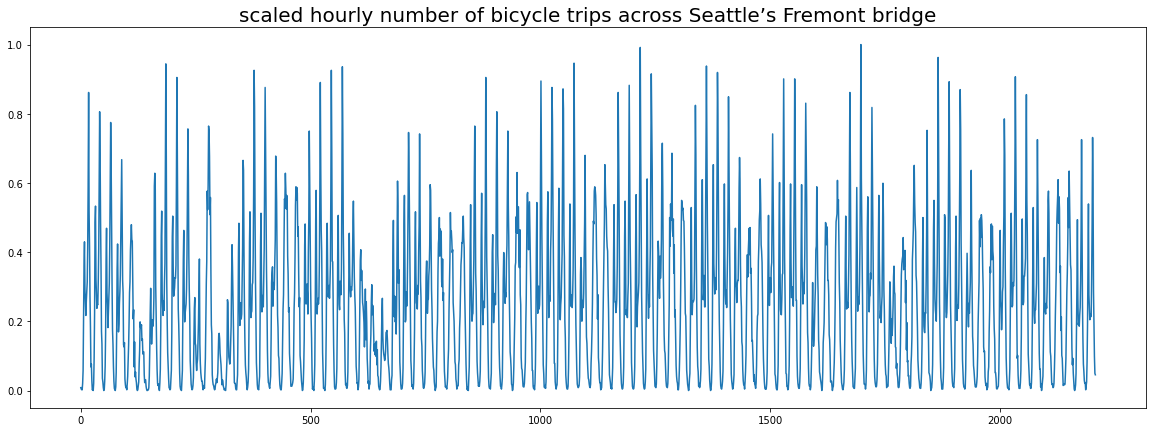

In [211]:
plt.figure(figsize=(20,7))
plt.plot(data)
plt.title('scaled hourly number of bicycle trips across Seattle’s Fremont bridge', fontsize=20)

The **goal** is to predict traffic 4 hours in advance

In [216]:
# create 24-hours windows
n = 24  # window size
series = np.zeros((len(data)-n,n))
for i in range(0,len(data)-n):
    series[i] = data[i:i+n]
series = series.reshape((len(data)-n,n,1))
series = np.random.permutation(series)

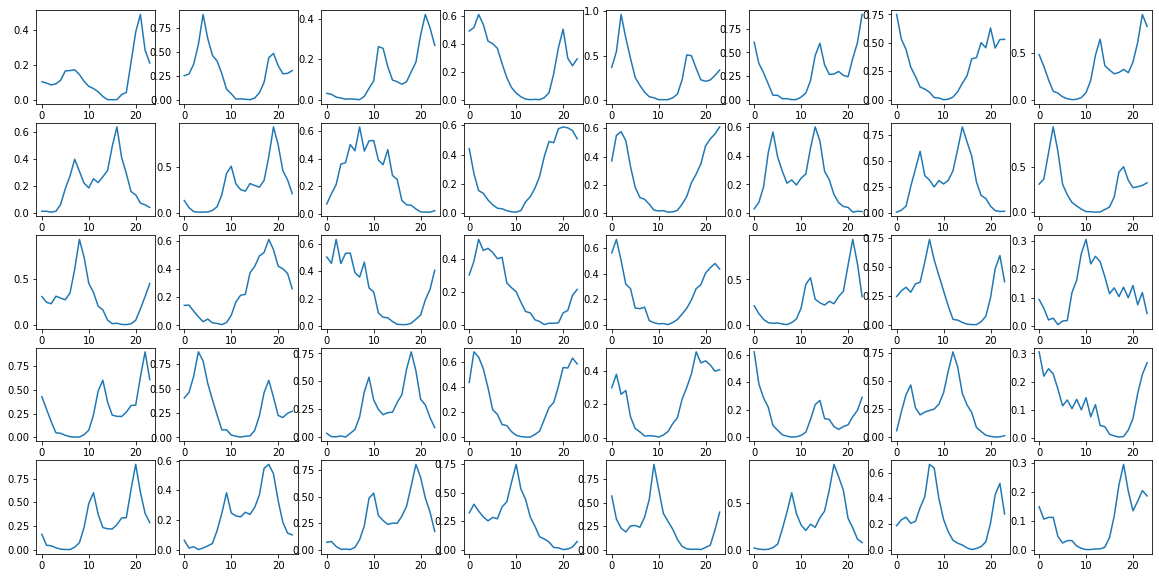

In [217]:
# plot some of the 24-hours windows
plt.figure(figsize=(20,10))
idx = 0
for i in range(5):
    for j in range(8):
        plt.subplot(5,8,idx+1)
        plt.plot(series[idx])
        idx+=1

In [218]:
# build a recurrent neural network (RNN)
layer1 = recurrent_layer(n_inputs=1, n_neurons=100)
activation1 = ReLU()

layer2 = recurrent_layer(n_inputs=100, n_neurons=50)
activation2 = ReLU()

layer3 = layer(n_inputs=50, n_neurons=1)
activation3 = linear()

loss = loss_mse()
optimizer = optimizer_GD(learning_rate=.5)

In [219]:
# train the RNN
n_epochs = 301
n_advance = 4

for epoch in range(n_epochs):
    # time step 0 - forward pass
    t = 0
    X = series[:,t,:]

    layer1.forward(X,np.zeros((len(X),layer1.n_neurons)))
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, np.zeros((len(X),layer2.n_neurons)))
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)

    losses = loss.forward(activation3.output, series[:,t+n_advance,:].flatten())

    # time step 0 - backward pass
    loss.backward(activation3.output, series[:,t+n_advance,:].flatten())

    activation3.backward(loss.dinputs)
    layer3.backward(activation3.dinputs)

    activation2.backward(layer3.dinputs)
    layer2.backward(activation2.dinputs)

    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)

    # update parameters
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.update_parameters(layer3)


    for t in range(1,20):
        X = series[:,t,:]

        # forward
        layer1.forward(X,layer1.output)
        activation1.forward(layer1.output)

        layer2.forward(activation1.output, activation2.output)
        activation2.forward(layer2.output)

        layer3.forward(activation2.output)
        activation3.forward(layer3.output)

        losses = loss.forward(activation3.output, series[:,t+n_advance,:].flatten())

        # backward pass
        loss.backward(activation3.output, series[:,t+n_advance,:].flatten())

        activation3.backward(loss.dinputs)
        layer3.backward(activation3.dinputs)

        activation2.backward(layer3.dinputs)
        layer2.backward(activation2.dinputs)

        activation1.backward(layer2.dinputs)
        layer1.backward(activation1.dinputs)

        # update parameters
        #optimizer.pre_update_parameters()
        optimizer.update_parameters(layer1)
        optimizer.update_parameters(layer2)
        optimizer.update_parameters(layer3)
        #optimizer.post_update_parameters()
        
    # print loss and accuracy
    if epoch % 10 == 0:
        print('epoch: '+str(epoch))
        print('loss: '+str(np.round(np.mean(losses),4)))
        print('------------------------')

epoch: 0
loss: 0.0382
------------------------
epoch: 10
loss: 0.0245
------------------------
epoch: 20
loss: 0.0132
------------------------
epoch: 30
loss: 0.0096
------------------------
epoch: 40
loss: 0.0084
------------------------
epoch: 50
loss: 0.008
------------------------
epoch: 60
loss: 0.0076
------------------------
epoch: 70
loss: 0.0074
------------------------
epoch: 80
loss: 0.0074
------------------------
epoch: 90
loss: 0.0073
------------------------
epoch: 100
loss: 0.0072
------------------------
epoch: 110
loss: 0.0075
------------------------
epoch: 120
loss: 0.01
------------------------
epoch: 130
loss: 0.0101
------------------------
epoch: 140
loss: 0.0056
------------------------
epoch: 150
loss: 0.0061
------------------------
epoch: 160
loss: 0.007
------------------------
epoch: 170
loss: 0.0064
------------------------
epoch: 180
loss: 0.0058
------------------------
epoch: 190
loss: 0.0069
------------------------
epoch: 200
loss: 0.0076
-----------

In [222]:
# plot some of the 24-hours windows together with the predicted traffic

# forward pass
t = 0
X = series[:,t,:]
y_pred = np.zeros((len(X),24))

layer1.forward(X,np.zeros((len(X),layer1.n_neurons)))
activation1.forward(layer1.output)

layer2.forward(activation1.output, np.zeros((len(X),layer2.n_neurons)))
activation2.forward(layer2.output)

layer3.forward(activation2.output)
activation3.forward(layer3.output)

y_pred[:,t] = activation3.output

for t in range(1,24):
    X = series[:,t,:]

    # forward
    layer1.forward(X,layer1.output)
    activation1.forward(layer1.output)

    layer2.forward(activation1.output, activation2.output)
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    
    y_pred[:,t] = activation3.output

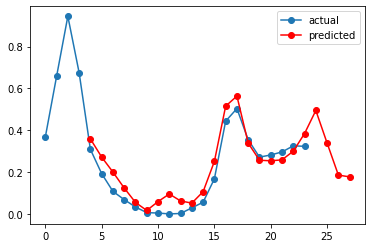

In [223]:
idx = np.random.randint(low=0,high=1000)
plt.plot(series[idx],'-o',label='actual')
plt.plot(np.arange(4,28),y_pred[idx],'-o',color='red',label='predicted')
plt.legend()

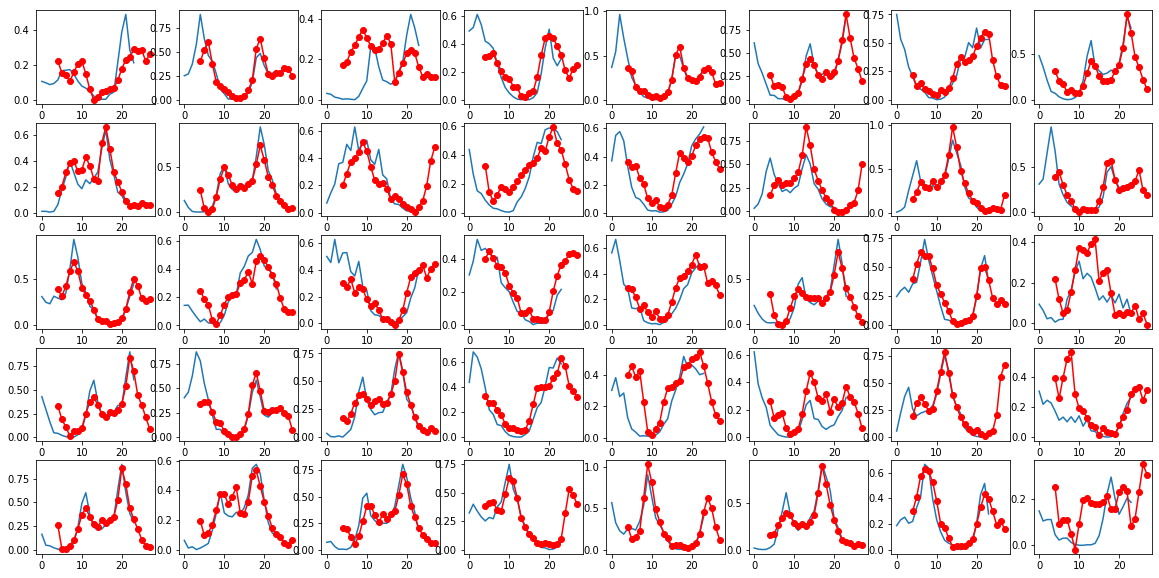

In [226]:
plt.figure(figsize=(20,10))
idx = 0
for i in range(5):
    for j in range(8):
        plt.subplot(5,8,idx+1)
        plt.plot(series[idx],label='actual')
        plt.plot(np.arange(4,28),y_pred[idx],'-o',color='red',label='predicted')
        idx+=1